# Higgs Challenge Example
In this part we will look at the **[Higgs Boson ML Challenge](https://www.kaggle.com/c/Higgs-boson)** on Kaggle and attempt a solution using Boosted Decision Trees (BDTs), a popular method in experimental particle physics. BDTs are based on an ensamble of weak classifiers (decision trees), and boosting increases the weight of misclassified events. Tomorrow, I will leave it as an excercise to try to get a solution using a neural network. The data is available from **[CERN Open Data](http://opendata.cern.ch/record/328)**. More information about the data is available from the links, and in particular at **[Documentation](http://opendata.cern.ch/record/329/files/atlas-higgs-challenge-2014.pdf)**. The general idea is that we want to extract $H\to\tau\tau$ signal from background. In particular, the selection requires one of the taus to decay into an electron or muon and two neutrinos, and the other into hadrons and a neutrino. The challenge is based on Monte Carlo events processed through the **[ATLAS detector](http://atlas.cern/)** simulation and reconstruction.


## Basic setup

In [2]:
# the usual setup: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# load training data
df = pd.read_csv('data/atlas-higgs-challenge-2014-v2.csv.gz')
len(dfread)

818238

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818238 entries, 0 to 818237
Data columns (total 35 columns):
EventId                        818238 non-null int64
DER_mass_MMC                   818238 non-null float64
DER_mass_transverse_met_lep    818238 non-null float64
DER_mass_vis                   818238 non-null float64
DER_pt_h                       818238 non-null float64
DER_deltaeta_jet_jet           818238 non-null float64
DER_mass_jet_jet               818238 non-null float64
DER_prodeta_jet_jet            818238 non-null float64
DER_deltar_tau_lep             818238 non-null float64
DER_pt_tot                     818238 non-null float64
DER_sum_pt                     818238 non-null float64
DER_pt_ratio_lep_tau           818238 non-null float64
DER_met_phi_centrality         818238 non-null float64
DER_lep_eta_centrality         818238 non-null float64
PRI_tau_pt                     818238 non-null float64
PRI_tau_eta                    818238 non-null float64
PRI_tau_phi

In [8]:
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


In [31]:
df.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleWeight
count,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,...,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000
mean,509118.500000,-48.819019,49.252714,81.140561,57.849524,-707.740880,-600.191191,-708.681306,2.373871,18.969617,...,-348.757840,-399.693294,-399.703858,-691.626111,-708.442206,-708.443312,73.205594,0.503144,0.341661,2.012577
std,236205.109119,406.118397,35.378609,40.582708,63.411938,454.793899,658.724040,453.328599,0.780875,21.918491,...,533.097006,489.428560,489.420013,480.274744,453.699150,453.697158,98.331754,0.572200,0.474267,5.439641
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000461,0.000000,0.000839
25%,304559.250000,78.166000,19.304000,59.414000,14.164250,-999.000000,-999.000000,-999.000000,1.814000,2.839000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.005721,0.000000,0.010415
50%,509118.500000,105.061000,46.484000,73.744000,38.470000,-999.000000,-999.000000,-999.000000,2.492000,12.383000,...,38.965000,-1.865000,-2.105000,-999.000000,-999.000000,-999.000000,40.506000,0.357223,0.000000,0.806562
75%,713677.750000,130.730000,73.620000,92.188000,79.226750,0.499000,84.031750,-4.548000,2.962000,27.634000,...,75.470750,0.432000,0.489000,33.800000,-2.436000,-2.265000,110.387000,0.733462,1.000000,2.360271
max,918237.000000,1949.261000,968.669000,1349.351000,2834.999000,8.724000,4974.979000,17.650000,5.751000,2834.999000,...,1163.439000,4.500000,3.142000,817.801000,4.500000,3.142000,1860.175000,2.386316,1.000000,106.908407


### Brief overview on variables, there is more information in the documentation. 
* The variables that start with **DER** are derived quantities, determined by the physicists performing the analysis as variables that discriminate signal from backround. 
* On the other hand, those that start with **PRI** are considered to be primary variables, from which the derived variables are calculated. They themselves generally do not provide much discrimination, but one of the ideas suggested by deep networks is that they can determine the necessary features from the primary variables, potentially even finding variables that the physicists did not consider. 
* *EventId* identifies the event but is not a "feature." 
* The *Weight* is the event weight. These are used to obtain the proper normalization of the different signal and background samples. The sum of weights of all signal events should produce the signal yield expected to be observed in 2012 LHC data taking. The sum of weights of all background events should produce the backgroudn yield. Note that the weight varies event to event, because different background and signal processes contribute to the background and signal sets. 
* *Label* indicates if it is a signal or background event. 
* Ignore the *Kaggle* variables--they are only used if you want to reproduce exactly what was used in the Challenge. 

### Investigate/visualize some parameters

In [12]:
import seaborn as sns

In [9]:
# Preprocessing:
# map y values to integers
df['Label'] = df['Label'].map({'b':0, 's':1})


In [20]:
df.keys()

Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label', 'KaggleSet', 'KaggleWeight'],
      dtype='object')

In [18]:
# take sub-set of vars for plotting
varplot = ['DER_mass_MMC', 'DER_mass_jet_jet',
       'DER_deltar_tau_lep', 'DER_pt_tot','PRI_jet_subleading_pt']


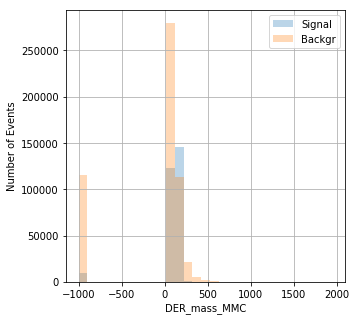

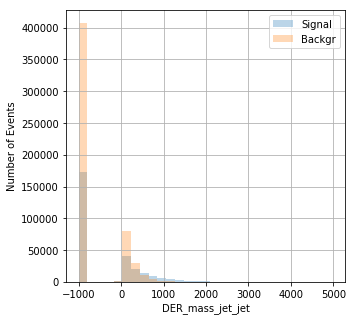

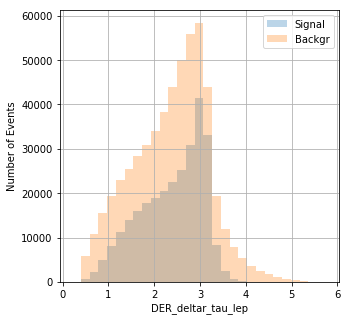

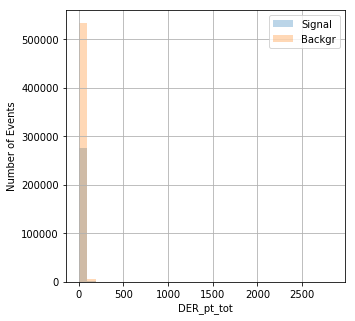

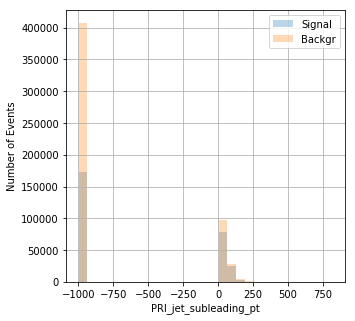

In [30]:
# direct histos
for key in varplot:
    # plotting settings
    fig = plt.figure(figsize=(5, 5))
    bins = np.linspace(min(df[key]), max(df[key]), 30)
    # plot signal & backg
    p = plt.hist([df[df['Label']==0][key],df[df['Label']==1][key]], bins=bins, stacked=True,label=['Backg','Signal'])
    
    # decorate
    plt.xlabel(key)
    plt.ylabel('Number of Events')
    plt.legend()
    plt.grid()
    plt.plot()

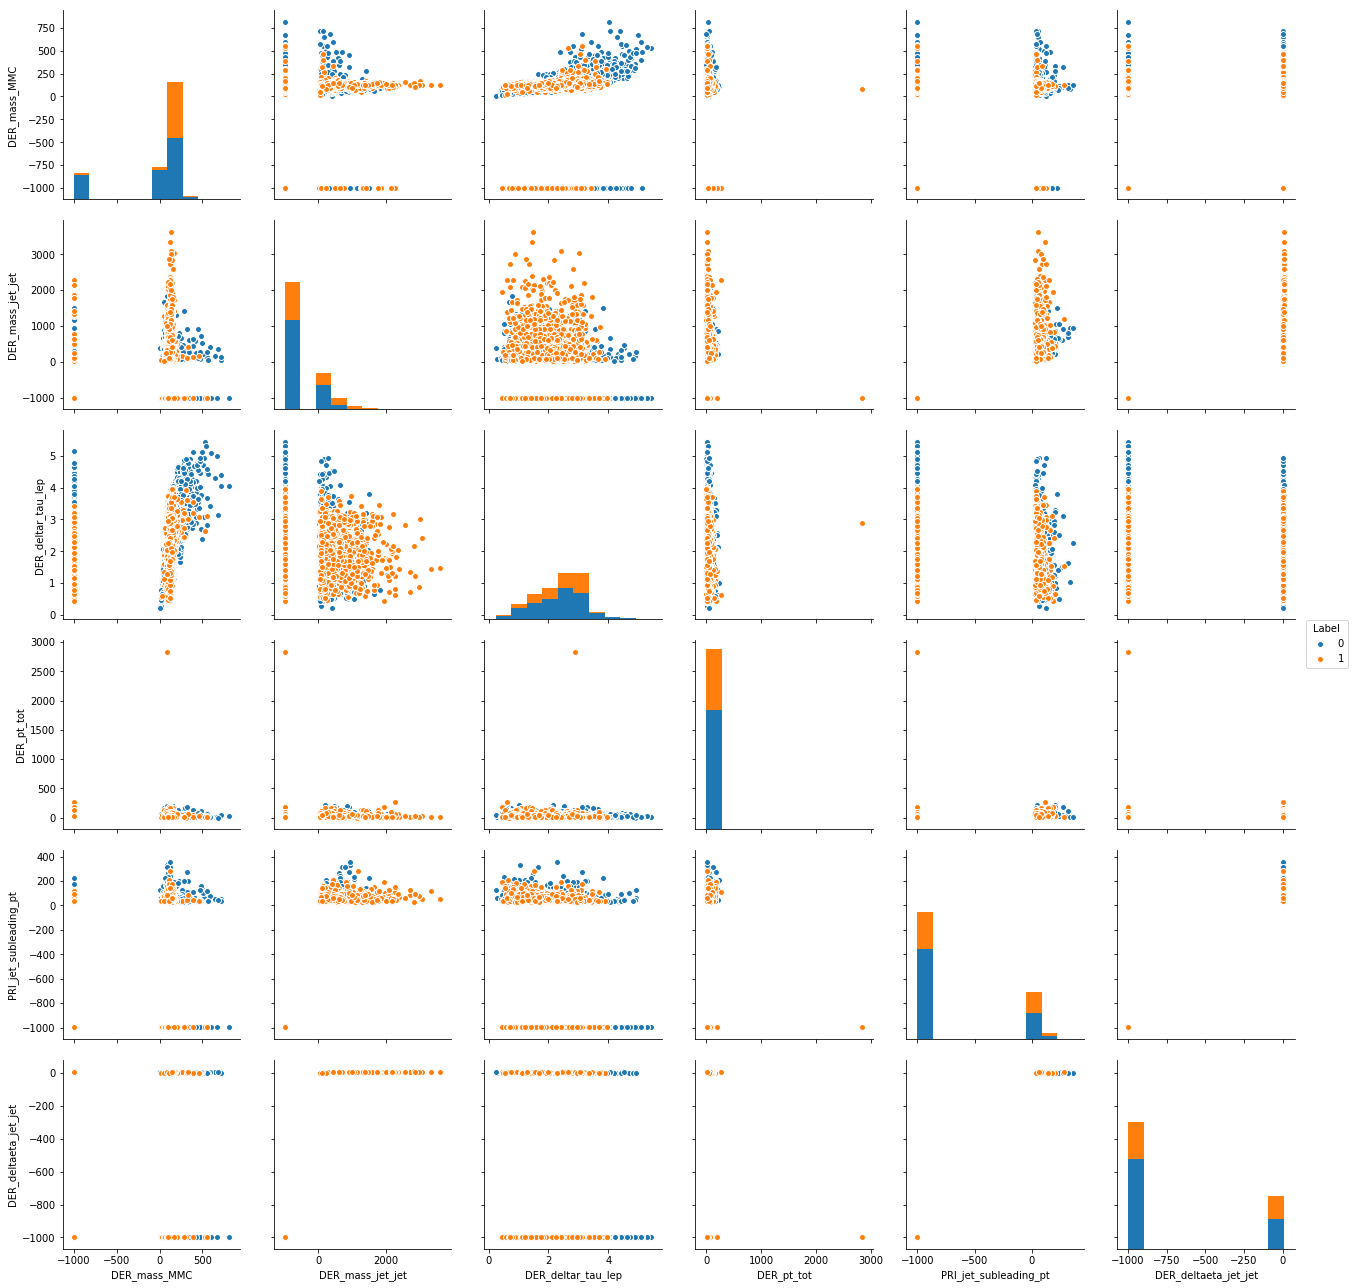

In [43]:
# plot only 1st 10k entries
sns.pairplot(df.iloc[:10000], hue='Label', size=3.0, vars=varplot)

### Further dataset preprocessing

In [44]:
# let's create separate arrays for ML models
eventID = df['EventId']
X = df.loc[:,'DER_mass_MMC':'PRI_jet_all_pt']
y = df['Label']
weight = df['Weight']

In [11]:
X.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,...,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000
mean,-48.819019,49.252714,81.140561,57.849524,-707.740880,-600.191191,-708.681306,2.373871,18.969617,158.596159,...,-0.008634,209.908730,0.979923,-348.757840,-399.693294,-399.703858,-691.626111,-708.442206,-708.443312,73.205594
std,406.118397,35.378609,40.582708,63.411938,454.793899,658.724040,453.328599,0.780875,21.918491,116.089809,...,1.812703,126.816686,0.978793,533.097006,489.428560,489.420013,480.274744,453.699150,453.697158,98.331754
min,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,46.103000,...,-3.142000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
25%,78.166000,19.304000,59.414000,14.164250,-999.000000,-999.000000,-999.000000,1.814000,2.839000,77.492000,...,-1.574000,122.985000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
50%,105.061000,46.484000,73.744000,38.470000,-999.000000,-999.000000,-999.000000,2.492000,12.383000,120.665000,...,-0.019000,179.883000,1.000000,38.965000,-1.865000,-2.105000,-999.000000,-999.000000,-999.000000,40.506000
75%,130.730000,73.620000,92.188000,79.226750,0.499000,84.031750,-4.548000,2.962000,27.634000,200.884500,...,1.559000,263.828000,2.000000,75.470750,0.432000,0.489000,33.800000,-2.436000,-2.265000,110.387000
max,1949.261000,968.669000,1349.351000,2834.999000,8.724000,4974.979000,17.650000,5.751000,2834.999000,2079.162000,...,3.142000,2190.275000,3.000000,1163.439000,4.500000,3.142000,817.801000,4.500000,3.142000,1860.175000


In [13]:
X.columns

Index(['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt'],
      dtype='object')

In [46]:
#now split into testing and training samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, eventID_train, event_ID_test, weight_train, weight_test = train_test_split(
    X, y, eventID, weight, test_size=0.33, random_state=42)

## First ML trials w/ simple models
1st attempt with simple models: GaussianNB and Logistic Regression
* train
* test
* plot scores


### GaussianNB

In [52]:
# GaussianNB
from sklearn.naive_bayes import GaussianNB # 1. choose model class
model = GaussianNB()                       # 2. instantiate model
model.fit(X_train, y_train)                  # 3. fit model to data
gnb = model.predict(X_test)             # 4. predict on new data

In [53]:
model.score(X_test, y_test)

0.6783633744292068

In [69]:
# define function to plot probability for sig/bg
def plot_proba( df, model, x ):
    df['Prob']=model.predict_proba(x)[:, 1]
    kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=40)
    df[df.Label==0].Prob.hist(label='Background',**kwargs)
    df[df.Label==1].Prob.hist(label='Signal',**kwargs)
    _=plt.legend()

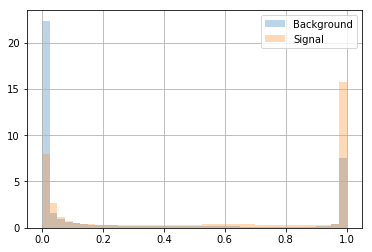

In [70]:
plot_proba( df, model, X)

###  Logistic Regression
As next attempt, let's look at logistic regression. This is a very simple, linear model. In the exercises you can look at optimizing it a bit more.

In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
lr = LogisticRegression()

In [61]:
# fit takes a while ...
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
lr.score(X_test,y_test)

0.7508471626070758

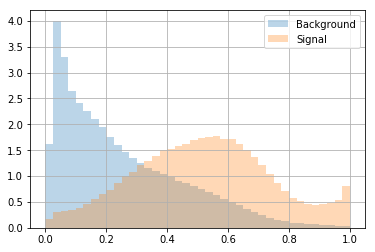

In [71]:
# check prob dist
plot_proba( df, lr, X)

####  Logistic Regression - v2
Now repeat but with fewer features

In [64]:
X_train.loc[:,:'DER_pt_tot'].columns

Index(['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot'],
      dtype='object')

In [65]:
# Let's try using fewer features
lr2 = LogisticRegression()

In [66]:
lr2.fit(X_train.loc[:,:'DER_pt_tot'], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [67]:
lr2.score(X_test.loc[:,:'DER_pt_tot'], y_test)

0.7172680441006003

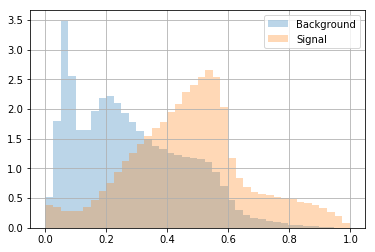

In [73]:
# check prob dist
plot_proba( df, lr2, X.loc[:,:'DER_pt_tot'])

## More sophisticated model -- GradientBoostingClassifier

In [74]:
# now let's define the model
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=50, max_depth=10,
                                    min_samples_leaf=200,
                                    max_features=10, verbose=1)


In [75]:
# and train
gbc.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2005            6.67m
         2           1.1311            6.77m
         3           1.0744            6.47m
         4           1.0266            6.47m
         5           0.9857            6.41m
         6           0.9515            6.31m
         7           0.9219            6.18m
         8           0.8959            5.99m
         9           0.8731            5.86m
        10           0.8529            5.74m
        20           0.7433            4.37m
        30           0.7037            2.72m
        40           0.6832            1.30m
        50           0.6710            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=10, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=200, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=1,
              warm_start=False)

In [76]:
gbc.score(X_test, y_test)

0.8427851373421871

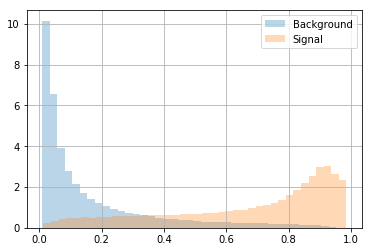

In [77]:
# check prob dist
plot_proba( df, gbc, X)

#### GBC also useful to judge/quantify features

In [78]:
gbc.feature_importances_

array([0.18966154, 0.09857256, 0.08370377, 0.026752  , 0.02561864,
       0.02806613, 0.00995706, 0.04797975, 0.03496498, 0.02113752,
       0.02403347, 0.04436499, 0.02715201, 0.06277108, 0.03257761,
       0.00409596, 0.01268001, 0.03692678, 0.00492783, 0.03499614,
       0.00495266, 0.02169181, 0.008404  , 0.01589533, 0.05569111,
       0.00582117, 0.00840441, 0.01037623, 0.00353146, 0.01429198])

In [89]:
for a,b in zip(gbc.feature_importances_, X.keys()):
    print ("%30s %6.3f" % (b,a))


                  DER_mass_MMC  0.190
   DER_mass_transverse_met_lep  0.099
                  DER_mass_vis  0.084
                      DER_pt_h  0.027
          DER_deltaeta_jet_jet  0.026
              DER_mass_jet_jet  0.028
           DER_prodeta_jet_jet  0.010
            DER_deltar_tau_lep  0.048
                    DER_pt_tot  0.035
                    DER_sum_pt  0.021
          DER_pt_ratio_lep_tau  0.024
        DER_met_phi_centrality  0.044
        DER_lep_eta_centrality  0.027
                    PRI_tau_pt  0.063
                   PRI_tau_eta  0.033
                   PRI_tau_phi  0.004
                    PRI_lep_pt  0.013
                   PRI_lep_eta  0.037
                   PRI_lep_phi  0.005
                       PRI_met  0.035
                   PRI_met_phi  0.005
                 PRI_met_sumet  0.022
                   PRI_jet_num  0.008
            PRI_jet_leading_pt  0.016
           PRI_jet_leading_eta  0.056
           PRI_jet_leading_phi  0.006
         PRI

## Figure-of-Merit AMS
Let's get back to the original problem using the GradientBoostingClassifier. The Kaggle competition used the approximate median significance (AMS), as defined below, to determine how good a solution was. 
The goal is to maximize signal and minimize background and the AMS is an approximate formula to quantify the signal significance, the maximal AMS gives best signal significance (the number 10, added to the background yield, is a regularization term to decrease the variance of the AMS.)

Note that if you do not use the full data set (i.e. you split into training and testing) you have to reweigh the inputs so that the subsample yield matches to the toal yield, which we will do below.

In [102]:
# compute approximate median segnificance (AMS)

def ams(s,b):
    from math import sqrt,log
    if b==0:
        return 0

    return sqrt(2*((s+b+10)*log(1+float(s)/(b+10))-s))


In [103]:
# Let's try a different probability cut, not the one given by default to predict().
# We choose the top 15%, but can optimize
y_train_prob = gbc.predict_proba(X_train)[:, 1]
y_test_prob = gbc.predict_proba(X_test)[:, 1]
pcut = np.percentile(y_train_prob,85)


In [104]:
print (pcut)

0.824163491485286



**Now include the weights** to get proper normalization  

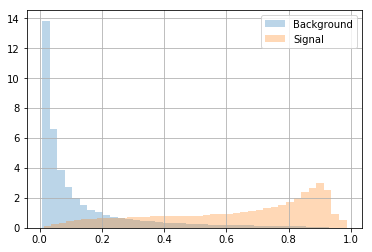

In [95]:
wgtsig=df[df.Label==1].Weight
wgtback=df[df.Label==0].Weight

kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=40)

df[df.Label==0].Prob.hist(label='Background',weights=wgtback,**kwargs)
df[df.Label==1].Prob.hist(label='Signal',weights=wgtsig,**kwargs)
plt.legend()

In [105]:
# Let's calculate the total weights (yields)
sigall = weight.dot(y)
backall = weight.dot(y == 0)

# The training weights
sigtrain = weight_train.dot(y_train)
backtrain = weight_train.dot(y_train == 0)

# The training weights
sigtest = weight_test.dot(y_test)
backtest = weight_test.dot(y_test == 0)

# aside:  these can also be done by looping instead of using a dot product
#  (Usually vectorized operations are faster for interpreted code)

In [106]:
# Now let's look at event yields that pass our selection
sigtrain_sel = weight_train.dot(np.multiply(y_train, y_train_prob > pcut))
backtrain_sel = weight_train.dot(np.multiply(y_train == 0, y_train_prob > pcut))

sigtest_sel = weight_test.dot(np.multiply(y_test, y_test_prob > pcut))
backtest_sel = weight_test.dot(np.multiply(y_test == 0, y_test_prob > pcut))


In [107]:
# Now we need to correct the selected yields to be is if we used the full sample
sigtrain_sel_corr = sigtrain_sel*sigall/sigtrain
backtrain_sel_corr = backtrain_sel*backall/backtrain

sigtest_sel_corr = sigtest_sel*sigall/sigtest
backtest_sel_corr = backtest_sel*backall/backtest

print("Corrected selected yields in training sample, signal =", sigtrain_sel_corr, ", background =",backtrain_sel_corr)
print("Corrected selected yields in test sample, signal =", sigtest_sel_corr, ", background =",backtest_sel_corr)


Corrected selected yields in training sample, signal = 225.73145154794952 , background = 3073.666756511348
Corrected selected yields in test sample, signal = 221.8254232042939 , background = 3800.2484150003293


In [108]:
print("AMS of training sample", ams(sigtrain_sel_corr,backtrain_sel_corr))
print("AMS of test sample", ams(sigtest_sel_corr,backtest_sel_corr))

AMS of training sample 4.0168392823841055
AMS of test sample 3.559591272977195


How did we do? Not too bad. Here are the scores of real submissions.
![Comparison with submissions](data/tr150908_davidRousseau_TMVAFuture_HiggsML.001.png)

This is of course a bit of a simplification from a real physics analysis, where systematics often seem to take the most time. They are ignored here.
![Comparison with real analysis](data/tr140415_davidRousseau_Rome_Higgs_MVA_HiggsML.001.png)

What to work on for the rest of the day:
1. Attempt to calculate the AMS for the logistic regression cases.
1. Do we overfit? Add plots to see.
1. Which variables are important?
1. Should we **[preprocess](http://scikit-learn.org/stable/modules/preprocessing.html)** the input data to be the same scale? Note that we have some -999 values that indicate the variable could not be calculated.
1. We do not use the event weights in the training. Can they help? Note, that you don't want to just apply the weights as is since they will make background dominate over signal.
1. The best scores in the Challenge all used cross-validation; if you have time, try to implement it.

Tomorrow we will continue on this example with neural networks.